<a href="https://colab.research.google.com/github/DarxinZ/ML/blob/main/T9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

class ITrainable:
    def __init__(self):
        pass

    def forward_propagation(self, prev_A):
        raise NotImplementedError("forward_propagation not implemented: ITrainable is an interface")

    def backward_propagation(self, dA):
        raise NotImplementedError("backward_propagation not implemented: ITrainable is an interface")

    def update_parameters(self):
        raise NotImplementedError("update_parameters not implemented: ITrainable is an interface")

    def save_parameters(self, file_path):
        pass

    def restore_parameters(self, file_path):
        pass

class DLLinearFamily(ITrainable):
    def __init__(self,name, n, alpha, optimization=None):
        self.name = name
        self.alpha = alpha
        self.optimization = optimization
        self.W = np.zeros((n,1),dtype=float)
        self.b = 0
        # optimization parameters
        if self.optimization == 'adaptive':
            self.adaptive_cont = 1.1
            self.adaptive_switch = 0.5
            self.adaptive_W = np.full(self.W.shape,alpha,dtype=float)
            self.adaptive_b = alpha
            
    def __str__(self):
        s = f"{self.name} Function:\n"
        s += f"\tlearning_rate (alpha): {self.alpha}\n"
        if self.optimization != None:
            s += f"\tOptimization: {self.optimization}\n"
            if self.optimization == "adaptive":
                s += f"\t\tadaptive parameters:\n"
                s += f"\t\t\tcont: {self.adaptive_cont}\n"
                s += f"\t\t\tswitch: {self.adaptive_switch}\n"
        s += "\tParameters:\n"
        s += f"\t\tW shape: {self.W.shape}\n"
        s += f"\t\tb: {self.b}\n"
        return s;


    def forward_propagation(self, prev_A):
        self.prev_A = np.copy(prev_A)
        Z = self.W.T@prev_A+self.b
        return Z

    def backward_propagation(self, dZ):
        db_m_values = dZ * np.full((1,self.prev_A.shape[1]),1)
        dW_n_m_values = dZ * self.prev_A
        self.db = np.sum(db_m_values, keepdims=True, axis=1)
        self.dW = np.sum(dW_n_m_values, keepdims=True, axis=1)
    
    def update_parameters(self):
        if self.optimization == 'adaptive':
            self.adaptive_W *= np.where(self.adaptive_W * self.dW > 0, self.adaptive_cont, -self.adaptive_switch)
            self.W -= self.adaptive_W 
            if self.adaptive_b * self.db > 0:
                self.adaptive_b *= self.adaptive_cont
            else:
                self.adaptive_b *= -self.adaptive_switch
            self.b -= self.adaptive_b 
        else:
            self.W -= self.alpha * self.dW
            self.b -= self.alpha * self.db

class DLLinearLayer(ITrainable):
    def __init__(self,name, num_units,input_size, alpha,optimization=None):
        self.name = name
        self.alpha = alpha
        self.num_units = num_units
        self.input_size = input_size
        self.optimization = optimization
        ##self.W = np.zeros((n,1),dtype=float)
        self.W = DLLinearLayer.normal_initialization((num_units,input_size), factor=1)
        self.W = DLLinearLayer.W_he_initialization(self)
        self.b = np.zeros((num_units,1),dtype=float)
        # optimization parameters
        if self.optimization == 'adaptive':
            self.adaptive_cont = 1.1
            self.adaptive_switch = 0.5
            self.adaptive_W = np.full(self.W.shape,alpha,dtype=float)
            self.adaptive_b = np.full(self.b.shape,alpha,dtype=float)
            ##self.adaptive_b = alpha
    
    def __str__(self):
        s = f"{self.name} Function:\n"
        s += f"\tlearning_rate (alpha): {self.alpha}\n"
        if self.optimization != None:
            s += f"\tOptimization: {self.optimization}\n"
            if self.optimization == "adaptive":
                s += f"\t\tadaptive parameters:\n"
                s += f"\t\t\tcont: {self.adaptive_cont}\n"
                s += f"\t\t\tswitch: {self.adaptive_switch}\n"
        s += "\tParameters:\n"
        s += f"\t\tW shape: {self.W.shape}\n"
        s += f"\t\tb: {self.b.shape}\n"
        s += f"\t\tnum units: {self.num_units}\n"
        s += f"\t\tinput size: {self.input_size}\n"
        return s;


    def forward_propagation(self, prev_A):
        self.prev_A = np.copy(prev_A)
        #Z = self.W.T@prev_A+self.b
        Z = self.W@prev_A+self.b
        return Z

    def backward_propagation(self, dZ):
        db_m_values = dZ * np.full((1,self.prev_A.shape[1]),1)
        #dW_n_m_values = dZ * self.prev_A
        #self.db = np.sum(db_m_values, keepdims=True, axis=1)
        #self.dW = np.sum(dW_n_m_values, keepdims=True, axis=1)
        self.dW = dZ@self.prev_A.T
        self.db = np.sum(db_m_values, keepdims=True, axis=1)
        dA_prev = self.W.T@dZ
        return dA_prev


    
    def update_parameters(self):
        if self.optimization == 'adaptive':
            self.adaptive_W *= np.where(self.adaptive_W * self.dW > 0, self.adaptive_cont, -self.adaptive_switch)
            self.W -= self.adaptive_W 
            #if self.adaptive_b * self.db > 0:
            #    self.adaptive_b *= self.adaptive_cont
            #else:
            #    self.adaptive_b *= -self.adaptive_switch
            #self.b -= self.adaptive_b 
            self.adaptive_b *= np.where(self.adaptive_b * self.db > 0, self.adaptive_cont, -self.adaptive_switch)
            self.b -= self.adaptive_b 
        else:
            self.W -= self.alpha * self.dW
            self.b -= self.alpha * self.db

    def W_he_initialization(self):
        W1 = self.W * np.sqrt(2/self.input_size)
        return W1

    def W_Xaviar_initialization(self):
        W1 = self.W * np.sqrt(1/self.input_size)
        return W1

    def save_parameters(self, file_path):
        file_name = file_path+"/"+self.name+".h5"
        with h5py.File(file_name, 'w') as hf:
            hf.create_dataset("W",  data=self.W)
            hf.create_dataset("b",  data=self.b)

    def restore_parameters(self, file_path):
        file_name = file_path+"/"+self.name+".h5"
        with h5py.File(file_name, 'r') as hf:
            self.W = hf['W'][:]
            self.b = hf['b'][:]

    @staticmethod
    def normal_initialization(shape,factor=0.01): 
        #W1 = np.random.randn(shape[0],shape[1]) * factor
        W1 = np.random.randn(*shape) * factor
        return W1



class DLNetwork(ITrainable):
    def __init__(self,name):
        self.name = name
        self.layers = []

    def __str__(self):
        s = f"{self.name}:\n"
        for l in self.layers:
            s += str(l)
        return s

    def add(self,iTrainable):
        for l in self.layers:
            if l.name == iTrainable.name:
                raise ValueError(f"{iTrainable.name} already exists")
        self.layers.append(iTrainable)

    def forward_propagation(self,X):
        Al=X
        for l in self.layers:
           Al = l.forward_propagation(Al)
        return Al

    def backward_propagation(self, dY_hat):
        dAl = dY_hat
        for l in reversed(self.layers):
           dAl = l.backward_propagation(dAl)
        return dAl

    def update_parameters(self):
        for l in self.layers:
           l.update_parameters()

    def save_parameters(self, directory_path):
        directory = directory_path+"/"+self.name
        os.makedirs(directory, exist_ok=True)
        for l in self.layers:
           l.save_parameters(directory)

    def restore_parameters(self, directory_path):
        directory = directory_path+"/"+self.name
        #os.makedirs(directory, exist_ok=True)
        for l in self.layers:
           l.restore_parameters(directory)

class DLActivation(ITrainable):
    #def __init__(self):
        #self.name = "Sigmoid"
    def __init__(self, activation):
        self.name = activation

    def __str__(self):
        return "Activation function: "+self.name+"\n"
    
    def forward_propagation(self,Z):
        if self.name == "sigmoid":
            self.S = 1/(1+np.exp(-Z))
            return self.S
        if self.name == "tanh":
            self.S = np.tanh(Z)
            return self.S
        if self.name == "relu":
            self.Z = Z
            return np.maximum(0,Z)
        if self.name == "leaky_relu":
            self.leakyRelu_d = 0.01
            self.Z = Z
            return np.where(Z <= 0, self.leakyRelu_d*Z, Z)
        raise NotImplementedError("Unimplemented activation:", self.name)

    def backward_propagation(self, dS):
        if self.name == "sigmoid":
            return dS * self.S * (1-self.S)
        if self.name == "tanh":
            return dS * (1-self.S * self.S)
        if self.name == "relu":
            return dS * np.where(self.Z <= 0, 0, 1)
        if self.name == "leaky_relu":
            return dS * np.where(self.Z <= 0, self.leakyRelu_d, 1)
        raise NotImplementedError("Unimplemented activation:", self.name)
    
    def update_parameters(self):
        pass

class DLPerceptron(DLNetwork):
    def __init__(self, name, n, alpha, optimization=None):
        DLNetwork.__init__(self, name)
        self.linear = DLLinearFamily("linear", n, alpha, optimization)
        self.sigmoid = DLActivation()
        self.add(self.linear)
        self.add(self.sigmoid)

class DLNeuronsLayer(DLNetwork):
    def __init__(self,name,num_units,input_size, activation, alpha,optimization=None):
        DLNetwork.__init__(self, name)
        self.linear = DLLinearLayer("linear", num_units,input_size, alpha,optimization)
        self.sigmoid = DLActivation(activation)
        self.add(self.linear)
        self.add(self.sigmoid)

class DLModel:
    def __init__(self,name,iTrainable, loss):
        self.name = name
        self.iTrainable = iTrainable
        self.loss = loss
        if loss == "square_dist":
            self.loss_forward = self.square_dist
            self.loss_backward = self.dSquare_dist
        elif loss == "cross_entropy":
            self.loss_forward = self.cross_entropy
            self.loss_backward = self.dCross_entropy
        else:
            raise NotImplementedError("Unimplemented loss function: " + loss)

    def __str__(self):
        s = self.name + "\n"
        s += "\tLoss function: " + self.loss + "\n"
        s += "\t"+str(self.iTrainable) + "\n"
        return s


    def square_dist(self, Y_hat, Y):
        errors = (Y_hat - Y)**2
        return errors

    def dSquare_dist(self, Y_hat, Y):
        m = Y.shape[1]
        dY_hat = 2*(Y_hat - Y)/m
        return dY_hat

    def compute_cost(self, Y_hat, Y):
        m = Y.shape[1]
        errors = self.loss_forward(Y_hat, Y)
        J = np.sum(errors)
        return J/m

    def cross_entropy(self, Y_hat, Y):
        eps = 1e-10
        Y_hat = np.where(Y_hat==0,eps,Y_hat)
        Y_hat = np.where(Y_hat == 1, 1-eps,Y_hat)
        logprobs = -((1 - Y)*np.log(1 - Y_hat)+Y*np.log(Y_hat))
        return logprobs

    def dCross_entropy(self, Y_hat, Y):
        eps = 1e-10
        Y_hat = np.where(Y_hat==0,eps,Y_hat)
        Y_hat = np.where(Y_hat == 1, 1-eps,Y_hat)
        m = Y_hat.shape[1]
        dY_hat =(1-Y)/(1-Y_hat)-Y/Y_hat
        return dY_hat/m

    def train(self, X, Y, num_iterations):
        print_ind = max(num_iterations // 100, 1)
        costs = []
        for i in range(num_iterations):
            Y_hat = self.forward_propagation(X)
            self.backward_propagation(Y_hat, Y)
            self.update_parameters()
            #record progress
            if i > 0 and i % print_ind == 0:
                J = self.compute_cost(Y_hat, Y)
                costs.append(J)
                print("cost after ", str(i+1), "updates ("+str(i//print_ind)+"%):",str(J))
        costs.append(self.compute_cost(Y_hat, Y))
        return costs

    def forward_propagation(self, X):
        return self.iTrainable.forward_propagation(X)

    def backward_propagation(self, Y_hat,Y):
        dY_hat = self.loss_backward(Y_hat, Y)
        self.iTrainable.backward_propagation(dY_hat)

    def update_parameters(self):
        self.iTrainable.update_parameters()

In [3]:
!cp /content/drive/MyDrive/Data/unit10/utils.py .
import utils as u10
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

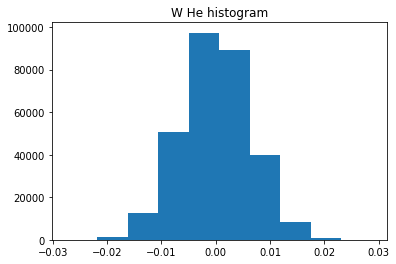

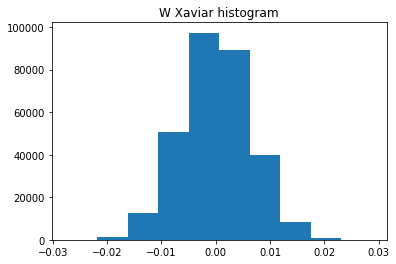

In [4]:
np.random.seed(1)
l = DLLinearLayer("Init W", 6,50000,0.001)
plt.hist(l.W.reshape(-1))
plt.title("W He histogram")
plt.show()
l.W_Xaviar_initialization()
plt.hist(l.W.reshape(-1))
plt.title("W Xaviar histogram")
plt.show()

In [5]:
import os
import h5py
np.random.seed(1)
my_first_ANN = DLNetwork("My first ANN")
hidden = DLNeuronsLayer("Hidden",4,2,"tanh",0.1,optimization='adaptive')
my_first_ANN.add(hidden)
output = DLNeuronsLayer("Output",1,4,"sigmoid",0.1,optimization='adaptive')
my_first_ANN.add(output)

path = r'/content/drive/MyDrive/Data' ## <=== change path to Data location
my_first_ANN.save_parameters(path)
hidden.linear.W = np.zeros(hidden.linear.W.shape)
my_first_ANN.restore_parameters(path)
print(hidden.linear.W)

[[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]
 [ 0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069 ]]


In [6]:
import h5py
import os
def load_datasetC1W2():
    return load_dataset(r'/drive/MyDrive/Data/unit10/datasets/cat_nocat')

def load_dataset(path):
    f = os.getcwd() + path
    train_dataset = h5py.File(f+r'/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(f + r'/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [7]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_datasetC1W2()
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
train_set_x = train_set_x_flatten/255 - 0.5
test_set_x = test_set_x_flatten/255 - 0.5
num_px = train_set_x_orig.shape[1]

In [8]:
np.random.seed(2)
hidden = DLNeuronsLayer("hidden",7,num_px*num_px*3, "relu", alpha=0.007,optimization='adaptive')
output = DLNeuronsLayer("output",1,7, "sigmoid", alpha=0.007,optimization='adaptive')
my_second_ANN = DLNetwork("ny second Ann")
my_second_ANN.add(hidden)
my_second_ANN.add(output)
print(my_second_ANN)
print(hidden.linear.W)
print(output.linear.W)

ny second Ann:
hidden:
linear Function:
	learning_rate (alpha): 0.007
	Optimization: adaptive
		adaptive parameters:
			cont: 1.1
			switch: 0.5
	Parameters:
		W shape: (7, 12288)
		b: (7, 1)
		num units: 7
		input size: 12288
Activation function: relu
output:
linear Function:
	learning_rate (alpha): 0.007
	Optimization: adaptive
		adaptive parameters:
			cont: 1.1
			switch: 0.5
	Parameters:
		W shape: (1, 7)
		b: (1, 1)
		num units: 1
		input size: 7
Activation function: sigmoid

[[-0.0053169  -0.00071784 -0.02725308 ... -0.01627269  0.00935618
   0.01487717]
 [ 0.00020509  0.00892398 -0.02735587 ... -0.00726816 -0.00352922
   0.00140539]
 [-0.00705641  0.00865931 -0.01110524 ...  0.0022279   0.00504696
  -0.00174069]
 ...
 [-0.01704517  0.00146999 -0.0026423  ...  0.01756093 -0.03036723
  -0.02032638]
 [ 0.00072691 -0.005927   -0.01294016 ...  0.00722408  0.00079215
  -0.00121153]
 [ 0.00754498  0.00788883 -0.00782201 ... -0.00896417  0.00762572
   0.00288979]]
[[ 0.07343335  0.2841

cost after  2 updates (1%): 4.239751554908064
cost after  3 updates (2%): 1.7883075259944254
cost after  4 updates (3%): 1.6613648748073746
cost after  5 updates (4%): 0.9291850691180634
cost after  6 updates (5%): 0.6456860433291112
cost after  7 updates (6%): 0.5949633712351683
cost after  8 updates (7%): 0.5438397371521617
cost after  9 updates (8%): 0.4804653740540899
cost after  10 updates (9%): 0.4459218772745918
cost after  11 updates (10%): 0.4133671575770859
cost after  12 updates (11%): 0.3850261032615267
cost after  13 updates (12%): 0.3596044567665581
cost after  14 updates (13%): 0.3384223472547015
cost after  15 updates (14%): 0.32156638851568164
cost after  16 updates (15%): 0.3087146357987029
cost after  17 updates (16%): 0.295096914530259
cost after  18 updates (17%): 0.2820445217348668
cost after  19 updates (18%): 0.26920446168605977
cost after  20 updates (19%): 0.25685086453752626
cost after  21 updates (20%): 0.24493513851980295
cost after  22 updates (21%): 0.233

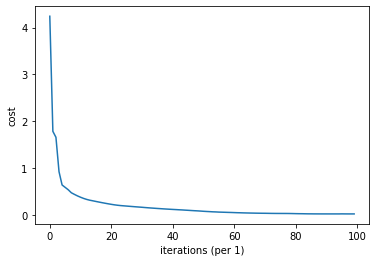

train accuracy: 98.08612440191388 %
test accuracy: 74.0 %


In [9]:
model2 = DLModel("second ann",my_second_ANN,"cross_entropy")
costs = model2.train(train_set_x, train_set_y,100)
u10.print_costs(costs,100)
threshold = 0.7
train_Y_hat = model2.forward_propagation(train_set_x) > threshold
print("train accuracy: {} %".format(100 - np.mean(np.abs(train_Y_hat - train_set_y)) * 100))
test_Y_hat = model2.forward_propagation(test_set_x) > threshold
print("test accuracy: {} %".format(100 - np.mean(np.abs(test_Y_hat - test_set_y)) * 100))

In [10]:
np.random.seed(0)
hidden1 = DLNeuronsLayer("hidden1",20,num_px*num_px*3, "relu", alpha=0.007,optimization='adaptive')
hidden2 = DLNeuronsLayer("hidden2",5,20, "relu", alpha=0.007,optimization='adaptive')
output = DLNeuronsLayer("output",1,5, "sigmoid", alpha=0.007,optimization='adaptive')
my_third_ANN = DLNetwork("my third Ann")
my_third_ANN.add(hidden1)
my_third_ANN.add(hidden2)
my_third_ANN.add(output)
print(my_third_ANN)
print(hidden1.linear.W)
print(hidden2.linear.W)
print(output.linear.W)

my third Ann:
hidden1:
linear Function:
	learning_rate (alpha): 0.007
	Optimization: adaptive
		adaptive parameters:
			cont: 1.1
			switch: 0.5
	Parameters:
		W shape: (20, 12288)
		b: (20, 1)
		num units: 20
		input size: 12288
Activation function: relu
hidden2:
linear Function:
	learning_rate (alpha): 0.007
	Optimization: adaptive
		adaptive parameters:
			cont: 1.1
			switch: 0.5
	Parameters:
		W shape: (5, 20)
		b: (5, 1)
		num units: 5
		input size: 20
Activation function: relu
output:
linear Function:
	learning_rate (alpha): 0.007
	Optimization: adaptive
		adaptive parameters:
			cont: 1.1
			switch: 0.5
	Parameters:
		W shape: (1, 5)
		b: (1, 1)
		num units: 1
		input size: 5
Activation function: sigmoid

[[ 0.02250535  0.00510511  0.0124865  ...  0.00649572 -0.00201916
   0.00882424]
 [-0.00140625  0.00267687 -0.00342447 ...  0.00121586 -0.00475532
  -0.01358523]
 [-0.00378281  0.01028787  0.01102311 ... -0.01349034  0.00175716
  -0.00231875]
 ...
 [ 0.00241606 -0.01007801 -0.

cost after  3 updates (1%): 8.668988699125885
cost after  5 updates (2%): 2.5998314360009367
cost after  7 updates (3%): 2.0230805745566465
cost after  9 updates (4%): 0.8389331521592837
cost after  11 updates (5%): 0.5410862871748539
cost after  13 updates (6%): 0.3650278499889139
cost after  15 updates (7%): 0.23416200697571898
cost after  17 updates (8%): 0.18399043787566915
cost after  19 updates (9%): 0.12966712897199512
cost after  21 updates (10%): 0.09804485568043726
cost after  23 updates (11%): 0.07316602371949289
cost after  25 updates (12%): 0.05648134334646047
cost after  27 updates (13%): 0.04465900110634989
cost after  29 updates (14%): 0.035803875886078224
cost after  31 updates (15%): 0.028559554688440403
cost after  33 updates (16%): 0.019975072993349496
cost after  35 updates (17%): 0.012702026818074141
cost after  37 updates (18%): 0.008612643635562033
cost after  39 updates (19%): 0.0063654118115022895
cost after  41 updates (20%): 0.0045605387665700195
cost after 

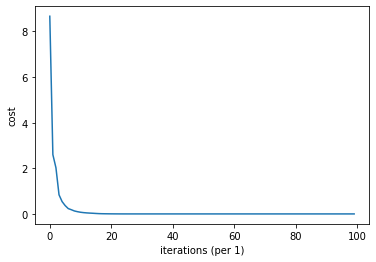

train accuracy: 100.0 %
test accuracy: 82.0 %


In [11]:
model3 = DLModel("third ann",my_third_ANN,"cross_entropy")
costs = model3.train(train_set_x, train_set_y,200)
u10.print_costs(costs,100)
threshold = 0.7
train_Y_hat = model3.forward_propagation(train_set_x) > threshold
print("train accuracy: {} %".format(100 - np.mean(np.abs(train_Y_hat - train_set_y)) * 100))
test_Y_hat = model3.forward_propagation(test_set_x) > threshold
print("test accuracy: {} %".format(100 - np.mean(np.abs(test_Y_hat - test_set_y)) * 100))
path = r'/content/drive/MyDrive/Data' ## <=== change path
my_third_ANN.save_parameters(path)
